Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.2178 - val_loss: 0.0309
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0248 - val_loss: 0.0031
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0051 - val_loss: 0.0055
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0028 - val_loss: 7.7226e-04
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0021 - val_loss: 5.3083e-04
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0013 - val_loss: 2.2241e-04
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.2706e-04 - val_loss: 2.2988e-04
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.6341e-04 - val_loss: 2.1675e-04
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.8727e-04 - val_loss: 3.3108e-04
Epoch 10/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.6718e-04 - val_loss: 1.7264e-04
Epoch 11/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.7735e-04 - val_loss: 1.9190e-04
Epoch 12/100
7/7 ━━━━━━━━━━━━━━━

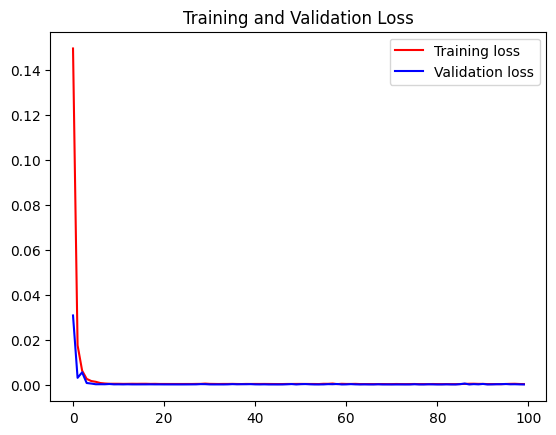

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


In [ ]:
import pandas as pd
import numpy as np
import datetime
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score
import math

# Load and preprocess data
df = pd.read_csv('BTC-ETH.csv')
df = df[['Date', 'Close', 'ETH_Close']]
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')

# Set 'Date' as index
df.set_index('Date', inplace=True)

# Normalize data
scaler = MinMaxScaler()
df[['Close', 'ETH_Close']] = scaler.fit_transform(df[['Close', 'ETH_Close']])

# Define the windowing function
def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
    first_date = pd.to_datetime(first_date_str)
    last_date = pd.to_datetime(last_date_str)
    target_date = first_date
    dates = []
    X, Y = [], []

    while True:
        # Check if there's enough data to form a window
        if len(dataframe.loc[:target_date]) < n + 1:
            print(f'Not enough data to create window for date {target_date}. Skipping.')
            target_date += datetime.timedelta(days=1)
            if target_date > last_date:
                break
            continue

        df_subset = dataframe.loc[:target_date].tail(n+1)
        if len(df_subset) != n+1:
            print(f'Error: Window of size {n} is too large for date {target_date}. Skipping.')
            target_date += datetime.timedelta(days=1)
            if target_date > last_date:
                break
            continue

        close_values = df_subset['Close'].to_numpy()
        eth_close_values = df_subset['ETH_Close'].to_numpy()
        x = np.hstack([close_values[:-1].reshape(-1, 1), eth_close_values[:-1].reshape(-1, 1)])
        y = close_values[-1]

        dates.append(target_date)
        X.append(x)
        Y.append(y)

        next_week = dataframe.loc[target_date:target_date + datetime.timedelta(days=7)]
        if next_week.empty:
            break

        next_date = next_week.index[-1] + datetime.timedelta(days=1)
        if next_date > last_date:
            break

        target_date = next_date

    ret_df = pd.DataFrame({'Target Date': dates})
    X = np.array(X)

    # Ensure X is 3-dimensional
    if X.ndim == 2:
        X = X[:, :, np.newaxis]  # Add an extra dimension

    for i in range(n):
        ret_df[f'Target-{n-i}'] = X[:, i, 0]  # Bitcoin Close prices
        ret_df[f'ETH-{n-i}'] = X[:, i, 1]  # Ethereum Close prices

    ret_df['Target'] = Y
    return ret_df

# Create windowed data
windowed_df = df_to_windowed_df(df, '2018-02-01', '2024-08-08', n=3)

# Convert to numpy arrays
def windowed_df_to_date_X_y(windowed_dataframe):
    df_as_np = windowed_dataframe.to_numpy()
    dates = df_as_np[:, 0]
    middle_matrix = df_as_np[:, 1:-1]
    X = middle_matrix.reshape((len(dates), 3, 2))  # Ensure the correct shape
    Y = df_as_np[:, -1]
    return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

# Split data
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]
dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

# Reshape X for DNN input (flatten the last two dimensions)
X_train = X_train.reshape(X_train.shape[0], -1)
X_val = X_val.reshape(X_val.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

# Define DNN model
def create_dnn_model(input_shape):
    model = models.Sequential()
    model.add(layers.Input(shape=input_shape))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))

    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Create and compile the model
input_shape = (X_train.shape[1],)
model = create_dnn_model(input_shape)

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32, verbose=1)

# Plot training and validation loss
plt.plot(history.history['loss'], 'r', label='Training loss')
plt.plot(history.history['val_loss'], 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Predict and evaluate
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Rescale predictions and actual values back to original scale
scaler = MinMaxScaler()
scaler.fit(y_train.reshape(-1, 1))
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1, 1))
original_ytest = scaler.inverse_transform(y_test.reshape(-1, 1))


In [ ]:

print("Train data RMSE: ", math.sqrt(mean_squared_error(original_ytrain, train_predict)))
print("Train data MSE: ", mean_squared_error(original_ytrain, train_predict))
print("Train data MAE: ", mean_absolute_error(original_ytrain, train_predict))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_ytest, test_predict)))
print("Test data MSE: ", mean_squared_error(original_ytest, test_predict))
print("Test data MAE: ", mean_absolute_error(original_ytest, test_predict))




Train data RMSE:  0.01498665564994611
Train data MSE:  0.00022459985
Train data MAE:  0.008735959
-------------------------------------------------------------------------------------
Test data RMSE:  0.017576243213752955
Test data MSE:  0.00030892433
Test data MAE:  0.014128588


In [ ]:
print("Train data explained variance regression score:", explained_variance_score(original_ytrain, train_predict))
print("Test data explained variance regression score:", explained_variance_score(original_ytest, test_predict))



Train data explained variance regression score: 0.99568110704422
Test data explained variance regression score: 0.9941828846931458


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


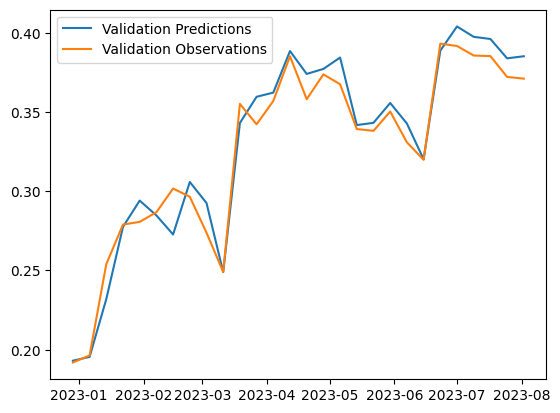

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


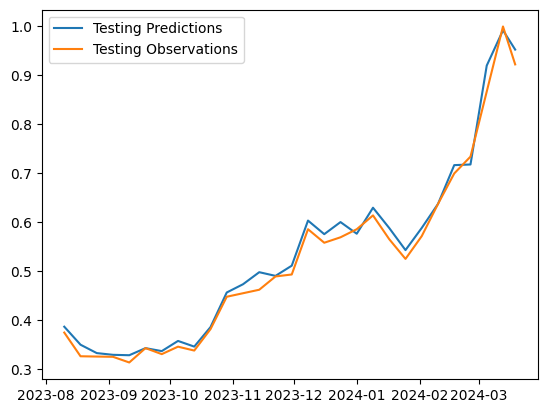

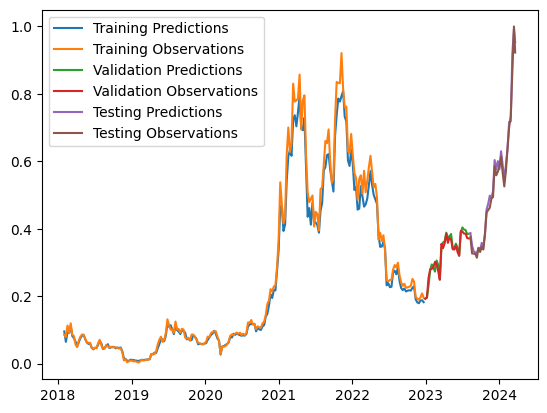

In [ ]:
# Plot predictions vs observations
val_predictions = model.predict(X_val).flatten()
plt.plot(dates_val, val_predictions, label='Validation Predictions')
plt.plot(dates_val, y_val, label='Validation Observations')
plt.legend()
plt.show()

test_predictions = model.predict(X_test).flatten()
plt.plot(dates_test, test_predictions, label='Testing Predictions')
plt.plot(dates_test, y_test, label='Testing Observations')
plt.legend()
plt.show()

plt.plot(dates_train, train_predict, label='Training Predictions')
plt.plot(dates_train, y_train, label='Training Observations')
plt.plot(dates_val, val_predictions, label='Validation Predictions')
plt.plot(dates_val, y_val, label='Validation Observations')
plt.plot(dates_test, test_predictions, label='Testing Predictions')
plt.plot(dates_test, y_test, label='Testing Observations')
plt.legend()
plt.show()

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


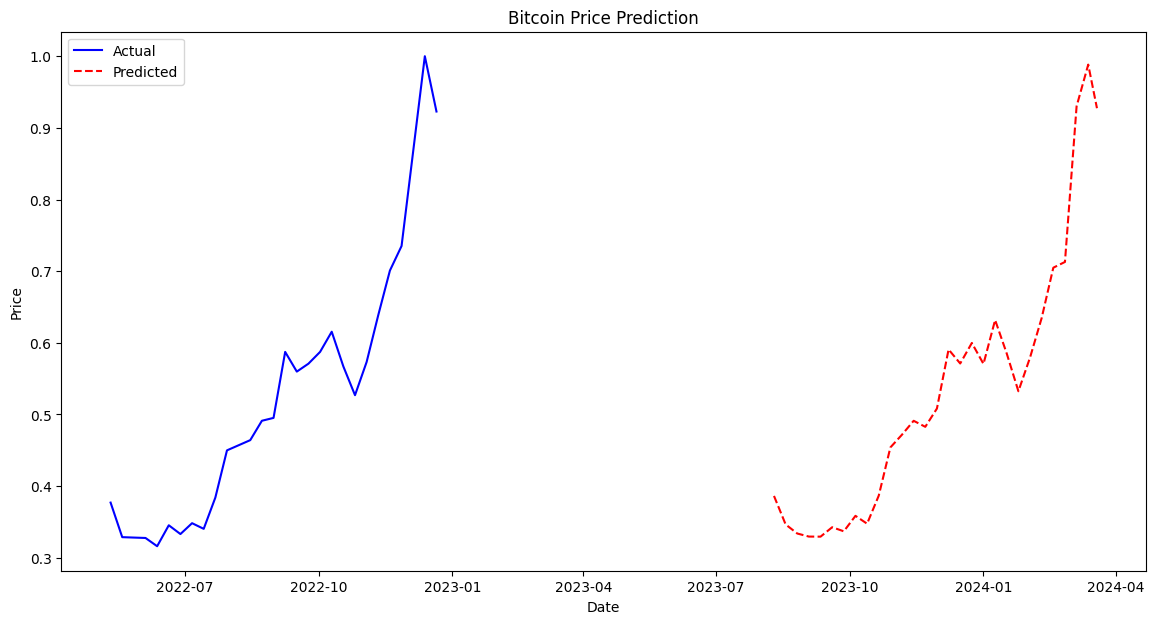

MSE: 0.0002941424027085304
MAE: 0.012336185202002525
Explained Variance: 0.9929777979850769


In [ ]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

scaler_y = MinMaxScaler()
scaler_y.fit(y.reshape(-1, 1))
train_predict = scaler_y.inverse_transform(train_predict)
test_predict = scaler_y.inverse_transform(test_predict)
original_ytrain = scaler_y.inverse_transform(y_train.reshape(-1, 1))
original_ytest = scaler_y.inverse_transform(y_test.reshape(-1, 1))

plt.figure(figsize=(14, 7))
plt.plot(dates_train[-len(original_ytest):], original_ytest, color='blue', label='Actual')
plt.plot(dates_test, test_predict, color='red', linestyle='--', label='Predicted')
plt.title('Bitcoin Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

mse = mean_squared_error(original_ytest, test_predict)
mae = mean_absolute_error(original_ytest, test_predict)
explained_variance = explained_variance_score(original_ytest, test_predict)

print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"Explained Variance: {explained_variance}")

